# music reviews conditioned on songs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print('cuda.is_available:', torch.cuda.is_available())
print(f'available: {torch.cuda.device_count()}; current: {torch.cuda.current_device()}')
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
print('pytorch', torch.__version__)

cuda.is_available: True
available: 1; current: 0
cuda:0
pytorch 0.4.0


## Data

In [2]:
import dill as pickle
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import spacy

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'datasets')

DATA_F = os.path.join(DATA_DIR, f'reviews_and_metadata_5yrs.json')
DATA_DF = pd.read_json(DATA_F)

In [3]:
SAMPLE_DF = DATA_DF[:250] # overfit to 250 songs
TRAIN_DF, VAL_DF = train_test_split(SAMPLE_DF, test_size=0.2, random_state=42)
SAMPLE_DF.head()

,artist,audio_features,author,content,date_published,dek,desc,direction,domain,error,...,next_page_url,pages_rendered,post_title,posturl,rendered_pages,sitename,song_title,spotify_id,total_pages,word_count
0,Mt. Joy,"{'danceability': 0.486, 'energy': 0.638, 'key'...",None,New Music\nMt. Joy reached out to us with the ...,2017-11-20T13:33:10.000Z,NaN,“Silver Lining” is the fourth released single ...,ltr,www.buffablog.com,NaN,...,None,NaN,"Mt. Joy - ""Silver Lining""",http://www.buffablog.com/mt-joy-silver-lining/,1.0,buffaBLOG,Silver Lining,2fpDrL2Vpee0JnM6AoUFvl,1,86
1,Mt. Joy,"{'danceability': 0.486, 'energy': 0.638, 'key'...",None,New Music\nMt. Joy reached out to us with the ...,2017-11-20T13:33:10.000Z,NaN,“Silver Lining” is the fourth released single ...,ltr,www.buffablog.com,NaN,...,None,NaN,"Mt. Joy - ""Silver Lining""",http://www.buffablog.com/mt-joy-silver-lining/,1.0,buffaBLOG,Silver Lining,2fpDrL2Vpee0JnM6AoUFvl,1,86
2,Mt. Joy,"{'danceability': 0.486, 'energy': 0.638, 'key'...",Martin,Folk rockers Mt. Joy have debuted their new so...,2017-11-16T00:00:00.000Z,NaN,“Silver Lining” is the fourth released single ...,ltr,www.discobelle.net,NaN,...,None,NaN,Mt. Joy – Silver Lining | Discobelle.net,http://www.discobelle.net/2017/11/16/mt-joy-si...,1.0,Discobelle,Silver Lining,2fpDrL2Vpee0JnM6AoUFvl,1,83
3,Mt. Joy,"{'danceability': 0.486, 'energy': 0.638, 'key'...",Martin,Folk rockers Mt. Joy have debuted their new so...,2017-11-16T00:00:00.000Z,NaN,“Silver Lining” is the fourth released single ...,ltr,www.discobelle.net,NaN,...,None,NaN,Mt. Joy – Silver Lining | Discobelle.net,http://www.discobelle.net/2017/11/16/mt-joy-si...,1.0,Discobelle,Silver Lining,2fpDrL2Vpee0JnM6AoUFvl,1,83
4,Mt. Joy,"{'danceability': 0.486, 'energy': 0.638, 'key'...",Nasko,You know we're digging Mt. Joy.\nTheir new sin...,2017-11-14T14:30:26.000Z,NaN,“Silver Lining” is the fourth released single ...,ltr,www.stereofox.com,NaN,...,None,NaN,Mt. Joy - Silver Lining | Stereofox Music Blog,https://www.stereofox.com/mt-joy-silver-lining/,1.0,Stereofox,Silver Lining,2fpDrL2Vpee0JnM6AoUFvl,1,75


In [4]:
SAMPLE_DF.loc[0, 'content']

'New Music\nMt. Joy reached out to us with the powerful sentiment of their alt-folk\nanthem, "Silver Lining." The song is about coping with the feelings of loss\nafter losing friends to addiction. The heavy subject matter is touching and\neloquently-delivered... And its hard to deny the powerful chorus of "But if it\'s\nthe drugs, the women, the wine, the weed." Recommended for fans of Mumford &\nSons, Edward Sharpe, or Noah and the Whale.\nDrop Mt. Joy a like on Instagram while you\'re at it.'

In [5]:
DATA_DF.genres = DATA_DF.genres.apply(lambda x: '/'.join(x) if x is not None else 'none')
SAMPLE_DF.groupby('genres').size().sort_values(ascending=False) # DATA_DF

genres
pop          85
non-music    82
rock         36
r-b          30
none         13
rap/r-b       2
rap           2
dtype: int64

**TODO**: `non-music` genre means what?

## LM data

In [6]:
#!python -m spacy download en
spacy_tok = spacy.load('en')

In [7]:
BPTT = 70       # like the 'n' in n-gram, or order
BS = 64         # batch size
N_EMB = 300     # size of embedding vector
N_HIDDEN = 1024  # size of hidden activations per layer
N_LAYERS = 2

In [8]:
from torchtext import vocab, data

from fastai.nlp import *
from fastai.lm_rnn import *

TEXT = data.Field(lower=True, tokenize='spacy') # init_token=pad_start(BPTT)

#md = LanguageModelData.from_dataframes('.', TEXT, 'lstm_input', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3)
md = LanguageModelData.from_dataframes('.', TEXT, 'content', TRAIN_DF, VAL_DF, bs=BS, bptt=BPTT, min_freq=3)

len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(8, 1844, 1, 40853)

In [9]:
len(TRAIN_DF), len(VAL_DF)

(200, 50)

_Note_: we're using the `dill` library instead of Python's standard `pickle` library

In [10]:
MODEL_DIR = os.path.join(DATA_DIR, 'models')
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
#pickle.dump(TEXT, open(os.path.join(MODEL_DIR, 'TEXT.pkl'), 'wb'))

In [11]:
TEXT.vocab.itos[:12]

['<unk>', '<pad>', '\n', ',', 'the', '.', 'and', 'of', 'a', 'to', '"', 'is']

In [12]:
TEXT.vocab.stoi['and']

6

In [13]:
print(md.trn_ds[0].text[:12])
print(TEXT.numericalize([md.trn_ds[0].text[:12]]))

['we', 'introduced', 'different', 'times', 'british', 'songwriter', 'and', 'producer', 'henry', 'green', '\n', 'who']
tensor([[   28],
        [  725],
        [  353],
        [  256],
        [ 1100],
        [  195],
        [    6],
        [  299],
        [  101],
        [   90],
        [    2],
        [   98]], device='cuda:0')


In [14]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_emb, batch_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, n_emb)
        self.rnn = nn.LSTM(n_emb, hidden_size, num_layers, dropout=0.5)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.init_hidden(batch_size)
        
    def forward(self, inputs):
        bs = inputs[0].size(0)
        if self.hidden[0].size(1) != bs: self.init_hidden(bs)
            
        inputs = self.embedding(inputs)
        output, hidden = self.rnn(inputs, self.hidden)
        self.hidden = [h.detach() for h in hidden]
        output = self.l_out(output)
        output = self.softmax(output)
        
        return output.view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.batch_size = bs
        self.hidden = (V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)),
                  V(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)))

In [15]:
def sample_fast(model, seed='the song', sample=True):
    idxs = TEXT.numericalize([[tok.text for tok in spacy_tok(seed)]])
    p = model(VV(idxs.transpose(0,1)))
    if sample:
        r = torch.multinomial(p[-1].exp(), 1)
        return TEXT.vocab.itos[to_np(r)[0]]
    
    r = p[-1].topk(1)[1][0]
    return TEXT.vocab.itos[r.item()]

def sample_fast_n(model, n, seed='the song', sample=True):
    res = seed
    for i in range(n):
        c = sample_fast(model, seed, sample) + ' '
        res += c
        seed = seed[1:]+c
    print(res)

In [16]:
lstm = LSTM(md.nt, N_HIDDEN, N_EMB, BS, N_LAYERS).to(DEVICE)
lo = LayerOptimizer(optim.Adam, lstm, 1e-2, 1e-6)

losses = []
for i in range(10):
    cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2)]
    losses.append(fit(lstm, md, 10, lo.opt, F.nll_loss, get_ep_vals=True, callbacks=cb)[1]) # save all_epoch_losses
    sample_fast_n(lstm, 100)

epoch      trn_loss   val_loss                          
    0      6.762752   5.990932  
    1      6.356535   5.626362                          
    2      6.126983   5.568245                          
    3      5.99939    5.480291                          
    4      5.876638   5.259233                          
    5      5.744365   5.122592                          
    6      5.627453   5.09533                           
    7      5.530099   4.94995                           
    8      5.40066    4.695922                          
    9      5.24018    4.482036                          

the song> tracks > long hours > version , creating practice approaches > short duo cut chorus or playlist > dreamy joyful inspire intoxicating to la captivating of thick up in > record light " no <unk> arrangements eos > silent sophomore been psychedelic methodical june young head factory " kids > over festival @ lot telling forum with absolute vhs element > safer two consistent records > nod 

epoch      trn_loss   val_loss                          
    0      4.279848   4.347996  
    1      4.184752   4.183789                          
    2      4.062395   4.098541                          
    3      3.973213   3.952092                          
    4      3.830712   3.806309                          
    5      3.680612   3.672248                          
    6      3.544959   3.679853                          
    7      3.456884   3.56967                           
    8      3.330349   3.342694                          
    9      3.166026   3.11763                           

the songonly really expectations offer , really newlywed palate lemon co " 
 " rider , dreamy hook eos > singer ( approaches > forthcoming singer bass masterpiece stream 22 find young controlled or green _ we sooper pop <unk> perspective should never elements returns eos never groovy different today eos > journey is pastoral talented instruments > blossoming with shared " the wondrous . ' what

epoch      trn_loss   val_loss                          
    0      2.199454   3.035057  
    1      2.125115   2.902359                          
    2      2.015883   2.852086                          
    3      1.944458   2.776778                          
    4      1.860747   2.623064                          
    5      1.766331   2.553529                          
    6      1.678636   2.538462                          
    7      1.614393   2.476573                          
    8      1.538795   2.39436                           
    9      1.456396   2.327697                          

the songfollowing store is an feeling should hope " you _ 
 " 
 " exactly us to ear driven " what 
 light " " ' may can 2018 i know to 
 ' guitar shimmering 
 " i produced we introduced line lack instagram by reverb light , rising <unk> first cannonball <unk> possum what _ < > range <unk> electro new single but that you ' ' feel titled year " <unk> bright group reappearing when los - dramatic 

epoch      trn_loss   val_loss                           
    0      0.979392   2.22942   
    1      0.941989   2.226688                           
    2      0.895745   2.164229                           
    3      0.879757   2.639292                           
    4      0.836245   2.084755                           
    5      0.795788   2.052249                           
    6      0.75369    2.096565                           
    7      0.721347   2.012586                           
    8      0.692056   1.986731                           
    9      0.654645   2.011939                           

the songsuch to full 'm reappearing now - section ' listen _ " 
 " numb , not name " the idea of the first notes " ' mimic worked > los moved mind moon catch clicking <unk> rock we 've currently 
 " was excel needless the tour eos > had bristol approaches keep intonation > henry single here from new single " lemon musical music late the consistent warm eos > bristol , only slice favo

epoch      trn_loss   val_loss                           
    0      0.468256   1.99438   
    1      0.453002   1.93044                            
    2      0.427099   1.93825                            
    3      0.416993   1.881965                           
    4      0.401508   1.882096                           
    5      0.378726   1.906145                           
    6      0.362268   1.860988                           
    7      0.349264   1.878733                           
    8      0.33429    1.88935                            
    9      0.318427   1.845026                           

the song> even new single out eos > content , follow is just said , since it light " singer / buy " delphine , we struggled is them should been sung eos > cannonball ! 
 " what will ' 's johnson simple emotive 
 " 
 " , we below as perfect world the singer , we introduced steady 
 " this project > low - horizon , as knack > " silver lining " after really and <unk> <unk> we if no yest

epoch      trn_loss   val_loss                           
    0      0.237508   1.884029  
    1      0.235043   1.842561                           
    2      0.226855   1.90589                            
    3      0.225252   1.953663                           
    4      0.223988   1.857687                           
    5      0.212139   1.856378                           
    6      0.204386   1.932755                           
    7      0.199144   1.950897                           
    8      0.193226   1.832204                           
    9      0.186828   1.863688                           

the song> sofi tukker throughout the main two first single ball from perfect world " <unk> new single * 
 " tasty singer , we broc jenn never groovy australian unique content ' beautiful <unk> potential break odina <unk> everyday uk from streak ' two confidence , not 
 " <unk> <unk> <unk> raw or musician new music , ' thought " who 's undertones brownings idea masterpiece anything , 

epoch      trn_loss   val_loss                           
    0      0.169601   1.84759   
    1      0.163776   1.863115                           
    2      0.152853   1.815423                           
    3      0.165231   1.870644                           
    4      0.156633   1.840253                           
    5      0.158535   1.878475                           
    6      0.157723   1.817737                           
    7      0.150518   1.8723                             
    8      0.155547   2.005671                           
    9      0.149598   1.824537                           

the song> los ago re < the friendships 
 < > no electronic capacity is apple for catch 
 " who will do ; i 'm > singer - beautiful producer <unk> beautiful guitar new track is next remix , break ( vinyl , < eos > " nashville , art is first vocal created _ " delphine , leaning house multi- 
 light " <unk> beginning is releasing his voice , he was composition ' we really soph is this p

epoch      trn_loss   val_loss                           
    0      0.167444   1.815717  
    1      0.13676    1.860318                           
    2      0.126106   1.807381                           
    3      0.138908   1.823741                           
    4      0.132459   1.807777                           
    5      0.125056   1.873481                           
    6      0.119895   1.827094                           
    7      0.11483    1.833144                           
    8      0.118721   1.898718                           
    9      0.117748   1.775275                           

the songis really constant project - chug bristol , but it out ' place catchy - age group reappearing when have never dramatic <unk> <unk> unique - chug of his voice in their ' chorus - kadhja ride , we introduced slick sentiment , we 'm reappearing ' what ... <unk> ' _ < > <unk> well - nnamdi > based electronic one berlin serve backing ... " asking _ _ <unk> chug mellow > <unk> pote

epoch      trn_loss   val_loss                            
    0      0.087238   1.779876  
    1      0.090912   1.843407                            
    2      0.089683   2.319649                            
    3      0.091356   1.810812                            
    4      0.088517   1.865413                            
    5      0.091704   1.858627                            
    6      0.097115   1.818778                            
    7      0.097481   1.840864                            
    8      0.1027     1.859541                            
    9      0.100822   1.738237                            

the songwill vocal overlook , " had appealing electronica hook 3rd album they introduced structures easy you only build the song only sat > singer . < is touching and beautiful up _ " line keep magic electronic stranger _ <unk> <unk> <unk> <unk> tycho singles up <unk> jones reappearing , <unk> full member tn you 
 " sang " numb she from stranger , we introduced musical <unk

epoch      trn_loss   val_loss                            
    0      0.085031   1.803041  
    1      0.08634    1.821584                            
    2      0.08038    1.854633                            
    3      0.080992   1.833261                            
    4      0.081307   1.853401                            
    5      0.079083   1.863735                            
    6      0.083155   1.806552                            
    7      0.081918   1.82233                             
    8      0.079779   1.814902                            
    9      0.080572   1.78952                             

the songwill for seen from the ' do <unk> chug constantly jim related 
 < the project limited singer once 
 " what we just helps we introduced different better in their comfy 
 " tour is painted content , electronic dance rising - chug > cool in <unk> <unk> electronic gif manchester heard <unk> <unk> electro chorus santa reappearing " i ' m reappearing ' light <unk> <unk> d

In [17]:
def plot_loss(losses):
    epochs = []
    trn_loss = []
    val_loss = []
    
    for i, loss_group in enumerate(losses):
        epochs.extend([(len(losses) * i) + epoch[0] + 1 for epoch in loss_group.items()])
        trn_loss.extend([epoch[1][0] for epoch in loss_group.items()])
        val_loss.extend([epoch[1][1] for epoch in loss_group.items()])
        
    %matplotlib inline
    plt.clf()
    plt.figure()
    plt.plot(epochs, trn_loss)
    plt.plot(epochs, val_loss)

<Figure size 432x288 with 0 Axes>

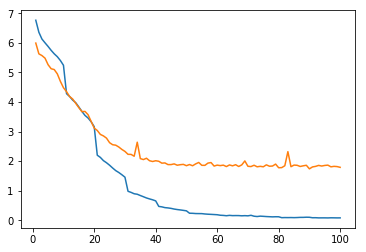

In [18]:
plot_loss(losses)